# <u> DSCI 100 Group 16 Project<u>

### Predicting Response for a Superstore Marketing Campaign

## <u> Introduction<u>

The marketing budgets for companies are skyrocketing these days, but looking at the depression coming in companies are cutting down on the marketing budgets and are finding much more better and economical ways to market their product. In today's competitive market, businesses often offer various discounts and benefits to their customers to retain them and encourage future purchases. One such strategy is the introduction of membership programs, which offer exclusive deals and discounts to customers who subscribe to them. (https://www.cnbc.com/2019/05/22/hooked-how-costco-turns-customers-into-fanatics.html)

In this project, we will utilize a dataset(https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset). This data set has over 2200 observations. Each observation has 14 variables which are Income, Recency, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, Response, Childhome, Age, Total_Spent, Weeks_Customer, Relationship. However for this project the main focus will be on the columns marital status, income, number of children, age, total spent, and time as customer.
    
Through this project we aim to predict “will an existing customer at the Superstore will be giving a positive response to their new gold membership offer which gives them 20% off for \\$499 which is \\$999 on regular days?”

## <u> Methods <u>

### Modifying the data set

The data set is already tidy, but we made the data set a bit more usable by:
- removing rows with 'NA'
- removing discrete variables
- creating a column for total children
- creating a column for total grocery spending
- converting the birthday column to age
- creating a column for time as customer
- changing the marital status to Yes/No factor
- changing the response variable to a factor

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
set.seed(16)
url <- "https://raw.githubusercontent.com/nchan315/DSCI_100_007_16_Project/main/superstore_data.csv"
data <- read_csv(url)

store_data <- data |>
    # removing rows with NA
    na.omit() |>

    # removing discrete variables
    select(-Id, -Education, -Complain) |>

    # summing the number of children
    mutate(Childhome = Kidhome + Teenhome) |>
    select(-Kidhome, -Teenhome) |>

    # creating an age column
    mutate(Age = 2022 - Year_Birth) |>
    select(-Year_Birth) |>

    # combining the amount spent on food
    mutate(Total_Spent = MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts) |>
    select(-MntWines, -MntFruits, -MntMeatProducts, -MntFishProducts, -MntSweetProducts) |>

    # calculating weeks that the customer has been a customer
    mutate(Dt_Customer = as.Date(Dt_Customer, "%m/%d/%Y")) |>
    mutate(Weeks_Customer = difftime("2022-12-31", Dt_Customer, units = "weeks")) |>
    mutate(Weeks_Customer = as.numeric(Weeks_Customer)) |>
    select(-Dt_Customer) |>

    # changing martial status into 2 distinctions
    mutate(Relationship = case_when(Marital_Status == 'Married' | Marital_Status == 'Together' ~ 'Yes',
                                    Marital_Status !=  'Married' & Marital_Status != 'Together' ~ 'No')) |>
    select(-Marital_Status) |>
    mutate(Relationship = as.factor(Relationship)) |>

    # changing response to a factor
    mutate(Response = as.factor(Response))

glimpse(store_data)

Rows: 2240 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Education, Marital_Status, Dt_Customer
dbl (19): Id, Year_Birth, Income, Kidhome, Teenhome, Recency, MntWines, MntF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 2,216
Columns: 14
$ Income              <dbl> 84835, 57091, 67267, 32474, 21474, 71691, 63564, 4…
$ Recency             <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ MntGoldProds        <dbl> 218, 37, 30, 0, 34, 43, 65, 7, 5, 5, 26, 4, 102, 3…
$ NumDealsPurchases   <dbl> 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 2, 1, 1, 0, 4, 4,…
$ NumWebPurchases     <dbl> 4, 7, 3, 1, 3, 4, 10, 2, 6, 6, 5, 3, 3, 1, 25, 2, …
$ NumCatalogPurchases <dbl> 4, 3, 2, 0, 1, 7, 10, 1, 2, 2, 6, 1, 6, 1, 0, 1, 1…
$ NumStorePurchases   <dbl> 6, 7, 5, 2, 2, 5, 7, 3, 9, 9, 10, 6, 6, 2, 0, 5, 5…
$ NumWebVisitsMonth   <dbl> 1, 5, 2, 7, 7, 2, 6, 5, 4, 4, 1, 4, 1, 6, 1, 4, 4,…
$ Response            <fct> 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,…
$ Childhome           <dbl> 0, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 2, 2,…
$ Age                 <dbl> 52, 61, 64, 55, 33, 64, 68, 55, 68, 68, 75, 43, 63…
$ Total_Spent         <dbl> 972, 540, 221, 11, 57, 1149, 1150, 89, 539, 539, 1…
$ Weeks_Customer

Our dataset has 14 variables, but we decided to focus on the variables: Relationship, Income, Age, Childhome, Total_Spent, and Weeks_Customer because they seemed like possible factors that would influence a positive or negative response.

In [3]:
store_data_reduced <- store_data |>
    select(Relationship, Income, Age, Childhome, Total_Spent, Weeks_Customer, Response)
glimpse(store_data_reduced)

Rows: 2,216
Columns: 7
$ Relationship   <fct> No, No, Yes, Yes, No, No, Yes, Yes, Yes, Yes, Yes, Yes,…
$ Income         <dbl> 84835, 57091, 67267, 32474, 21474, 71691, 63564, 44931,…
$ Age            <dbl> 52, 61, 64, 55, 33, 64, 68, 55, 68, 68, 75, 43, 63, 41,…
$ Childhome      <dbl> 0, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 2, 2, 1, 1…
$ Total_Spent    <dbl> 972, 540, 221, 11, 57, 1149, 1150, 89, 539, 539, 1182, …
$ Weeks_Customer <dbl> 445.7143, 445.8571, 450.5714, 425.4286, 438.7143, 458.7…
$ Response       <fct> 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0…


### Creating the Testing/Training Split
We split the data set by martial status (Relationship column) and split the data into 75% training and 25% testing sets.

In [4]:
# creating the 75% training 25% testing split
store_data_yes_split <- store_data_reduced |>
    filter(Relationship == "Yes") |>
    initial_split(prop = 0.75, strata = Response)
store_data_yes_train <- training(store_data_yes_split)
store_data_yes_test <- testing(store_data_yes_split)

store_data_no_split <- store_data_reduced |>
    filter(Relationship == "No") |>
    initial_split(prop = 0.75, strata = Response)
store_data_no_train <- training(store_data_no_split)
store_data_no_test <- testing(store_data_no_split)

glimpse(store_data_yes_train)
glimpse(store_data_yes_test)
glimpse(store_data_no_train)
glimpse(store_data_no_test)

Rows: 1,072
Columns: 7
$ Relationship   <fct> Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, …
$ Income         <dbl> 32474, 44931, 65324, 81044, 62499, 26872, 54809, 36634,…
$ Age            <dbl> 55, 55, 68, 75, 43, 41, 45, 68, 43, 46, 66, 66, 36, 32,…
$ Childhome      <dbl> 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1, 1, 1…
$ Total_Spent    <dbl> 11, 89, 539, 1182, 218, 40, 152, 305, 69, 381, 652, 652…
$ Weeks_Customer <dbl> 425.4286, 467.0000, 426.0000, 470.1429, 485.2857, 480.4…
$ Response       <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
Rows: 358
Columns: 7
$ Relationship   <fct> Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, …
$ Income         <dbl> 67267, 65324, 4428, 34578, 66991, 76445, 75276, 77037, …
$ Age            <dbl> 64, 68, 53, 50, 68, 51, 57, 62, 53, 43, 60, 57, 69, 40,…
$ Childhome      <dbl> 1, 1, 1, 3, 0, 1, 0, 1, 0, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1…
$ Total_Spent    <dbl> 221, 539, 38, 8, 1241, 1375, 1019, 1113, 977, 668, 11

### Forward Selection

We used forward selection to determine the most relevant predictors for the different martial statuses.

This code was taken from 6.8 in online DSCI 100 textbook.

In [5]:
# Beginning of forward selection for Yes Relationship:
# (may take a while to run)

names <- colnames(store_data_yes_train |> select(-Response, -Relationship))

# create an empty tibble to store the results
yes_accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
store_vfold <- vfold_cv(store_data_yes_train, v = 5, strata = Response)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Response", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        store_recipe <- recipe(as.formula(model_string), 
                                data = store_data_yes_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(store_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = store_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    yes_accuracies <- yes_accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
yes_accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Response ~ Age,0.8899317
2,Response ~ Age+Childhome,0.8908619
3,Response ~ Age+Childhome+Total_Spent,0.8908575
4,Response ~ Age+Childhome+Total_Spent+Income,0.8917790
5,Response ~ Age+Childhome+Total_Spent+Income+Weeks_Customer,0.8918008


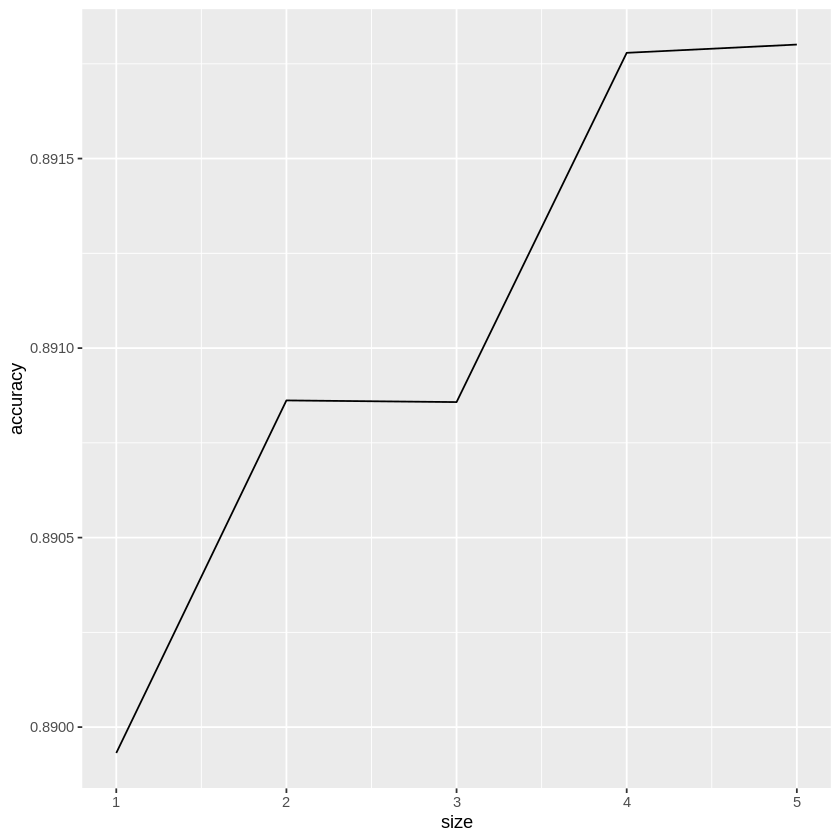

In [6]:
yes_plot <- yes_accuracies |>
    ggplot(aes(size, accuracy)) +
        geom_line()
yes_plot

In [7]:
# Beginning of forward selection for No Relationship:
# (may take a while to run)

names <- colnames(store_data_yes_train |> select(-Response, -Relationship))

# create an empty tibble to store the results
no_accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
store_vfold <- vfold_cv(store_data_no_train, v = 5, strata = Response)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Response", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        store_recipe <- recipe(as.formula(model_string), 
                                data = store_data_no_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(store_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = store_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    no_accuracies <- no_accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
no_accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Response ~ Income,0.8080778
2,Response ~ Income+Childhome,0.8097583
3,Response ~ Income+Childhome+Total_Spent,0.8063262
4,Response ~ Income+Childhome+Total_Spent+Weeks_Customer,0.7977787
5,Response ~ Income+Childhome+Total_Spent+Weeks_Customer+Age,0.7877386


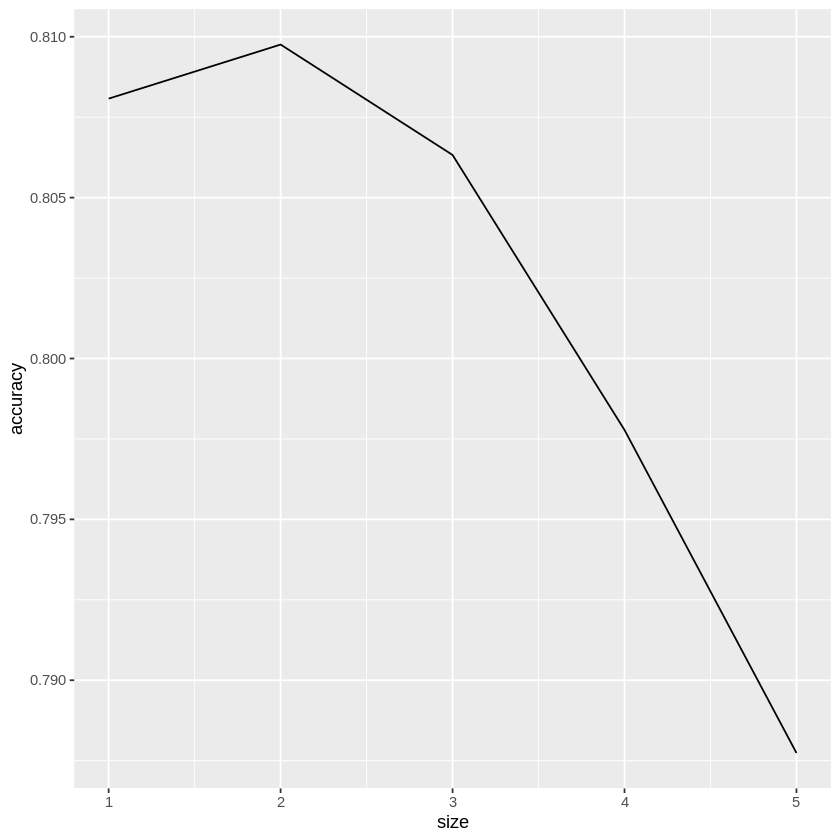

In [8]:
no_plot <- no_accuracies |>
    ggplot(aes(size, accuracy)) +
        geom_line()
no_plot

For the "yes" marital status, the most important predictors are Age, Childhome, Total_Spent, and Income. We see that Weeks_Customer is not as important because adding it to the model does not significantly change the accuracy of the model (it is only a 0.1% change).

For the "no" marital status, the most important predictors are Income and Childhome. We see that as we add the other predictors, the accuracy of the model decreases.

## Creating a Model for "Yes" Marital Status

Now that we know the best combination of predictors to use to obtain the highest accuracy, we'll test for how many neighbors we should use to obtain the highest accuracy. We first create a model with a variable amount of neighbours and then we will plot the estimated accuracy for different values of K.

In [9]:
store_yes_recipe <- recipe(Response ~ Age+Total_Spent+Income+Childhome, 
                                data = store_data_yes_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 101, by = 4))
                 
knn_results <- workflow() |>
          add_recipe(store_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = store_vfold, grid = k_vals) |>
    collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7298372,5,0.02786810,Preprocessor1_Model01
1,roc_auc,binary,0.6024132,5,0.03081624,Preprocessor1_Model01
5,accuracy,binary,0.7622425,5,0.01282263,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
97,roc_auc,binary,0.7598311,5,0.026025205,Preprocessor1_Model25
101,accuracy,binary,0.7793068,5,0.002124273,Preprocessor1_Model26
101,roc_auc,binary,0.7582372,5,0.027204803,Preprocessor1_Model26


In [10]:
accuracies <- knn_results |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
33,accuracy,binary,0.8115693,5,0.008504036,Preprocessor1_Model09
73,accuracy,binary,0.8081790,5,0.007656172,Preprocessor1_Model19
37,accuracy,binary,0.8081645,5,0.008616377,Preprocessor1_Model10
⋮,⋮,⋮,⋮,⋮,⋮,⋮
101,accuracy,binary,0.7793068,5,0.002124273,Preprocessor1_Model26
5,accuracy,binary,0.7622425,5,0.012822633,Preprocessor1_Model02
1,accuracy,binary,0.7298372,5,0.027868101,Preprocessor1_Model01


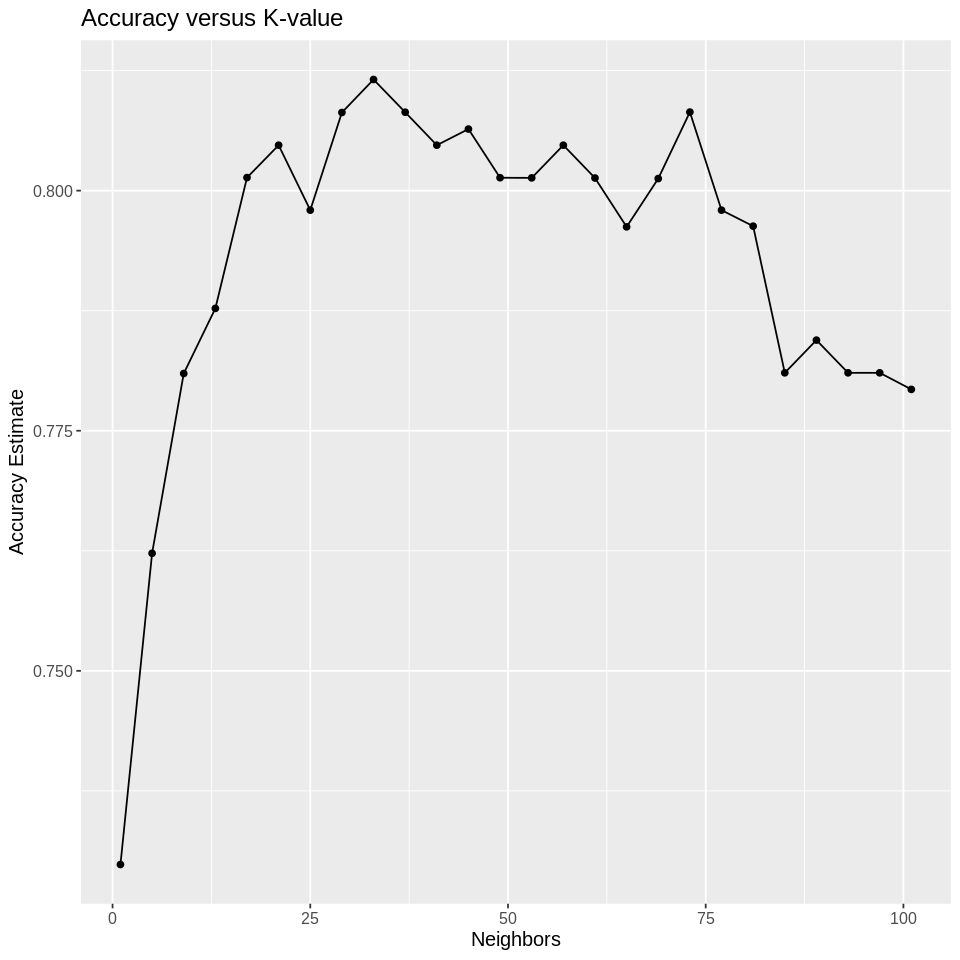

In [11]:
options(repr.plot.width = 8, repr.plot.height = 8)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    ggtitle("Accuracy versus K-value") +
    theme(text = element_text(size = 12))

accuracy_vs_k

From the graph above, we see that the best number of neighbors is around K = 33.

In [12]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 33) |>
    set_engine("kknn") |>
    set_mode("classification")

store_yes_fit <- workflow() |>
    add_recipe(store_yes_recipe) |>
    add_model(knn_best_spec) |>
    fit(data = store_data_yes_train)

In [13]:
store_yes_predictions <- predict(store_yes_fit, store_data_yes_test) |>
    bind_cols(store_data_yes_test)

store_yes_predictions

.pred_class,Relationship,Income,Age,Childhome,Total_Spent,Weeks_Customer,Response
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,Yes,67267,64,1,221,450.5714,0
0,Yes,65324,68,1,539,426.0000,0
0,Yes,4428,53,1,38,503.1429,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,Yes,42557,48,1,255,539.4286,0
0,Yes,20130,48,0,22,458.7143,0
0,Yes,65819,44,0,1320,526.2857,0


The estimated accuracy for the "yes" model is 88.83%.

In [14]:
store_yes_accuracy <- store_yes_predictions |>
    metrics(truth = Response, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1) |>
    pull()

store_yes_accuracy

[1] 0.8882682

### Creating a Model for "No" Marital Status

### Visualizing the Results

Since both the "yes" and "no" models use Income and Childhome as predictors, we can compare their scatterplot. This code was taken from 5.8 in the online DSCI 100 textbook.

Warning message:
“Removed 552 rows containing missing values (geom_point).”
Warning message:
“Removed 9200 rows containing missing values (geom_point).”


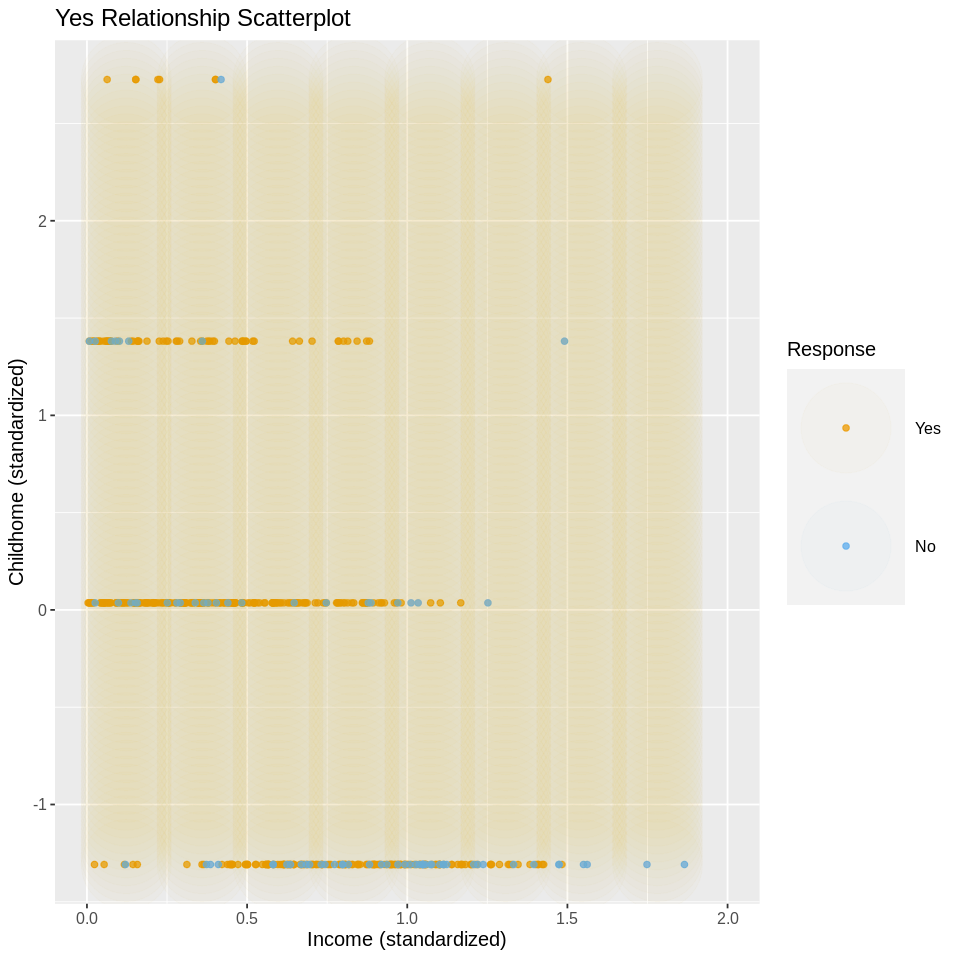

In [15]:
# code for Yes Relationship scatterplot
yes_data_modified <- store_data_yes_train |>
    select(Income, Childhome, Response) |>
    mutate(across(Income, scale)) |>
    mutate(across(Childhome, scale))

yes_recipe_modified <- recipe(Response ~ Income+Childhome, 
                                data = store_data_yes_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

store_yes_fit_modified <- workflow() |>
    add_recipe(yes_recipe_modified) |>
    add_model(knn_best_spec) |>
    fit(data = yes_data_modified)

# create the grid of income/childhome vals, and arrange in a data frame
income_grid <- seq(min(yes_data_modified$Income), 
                max(yes_data_modified$Income), 
                length.out = 100)
child_grid <- seq(min(yes_data_modified$Childhome), 
                max(yes_data_modified$Childhome), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(Income = income_grid, 
                                Childhome = child_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(store_yes_fit_modified, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(Class = .pred_class)

yes_scatterplot <- ggplot() +
    geom_point(yes_data_modified, 
               mapping = aes(Income, Childhome, color = Response),
               alpha = 0.75) +
    geom_point(prediction_table,
               mapping = aes(Income, Childhome, color = Class),
               alpha = 0.02,
               size = 25) +
    labs(color = "Response",
         x = "Income (standardized)", 
         y = "Childhome (standardized)") +
    scale_color_manual(labels = c("Yes", "No"),
                       values = c("orange2", "steelblue2")) +
    theme(text = element_text(size = 12)) +
    xlim(0, 2) +
    ggtitle("Yes Relationship Scatterplot")
yes_scatterplot

We see above that most people are likely to give a positive response to the promotion. There are no distinct regions where a customer is likely to say no. This shows that the predictors are likely not even that conclusive when it comes to predicting a response.

In [16]:
## space for the no scatterplot

For the "Yes" model, the predictors that we didn't use are Age and Total_Spent, so that scatterplot is below:

Warning message:
“Removed 1 rows containing missing values (geom_point).”


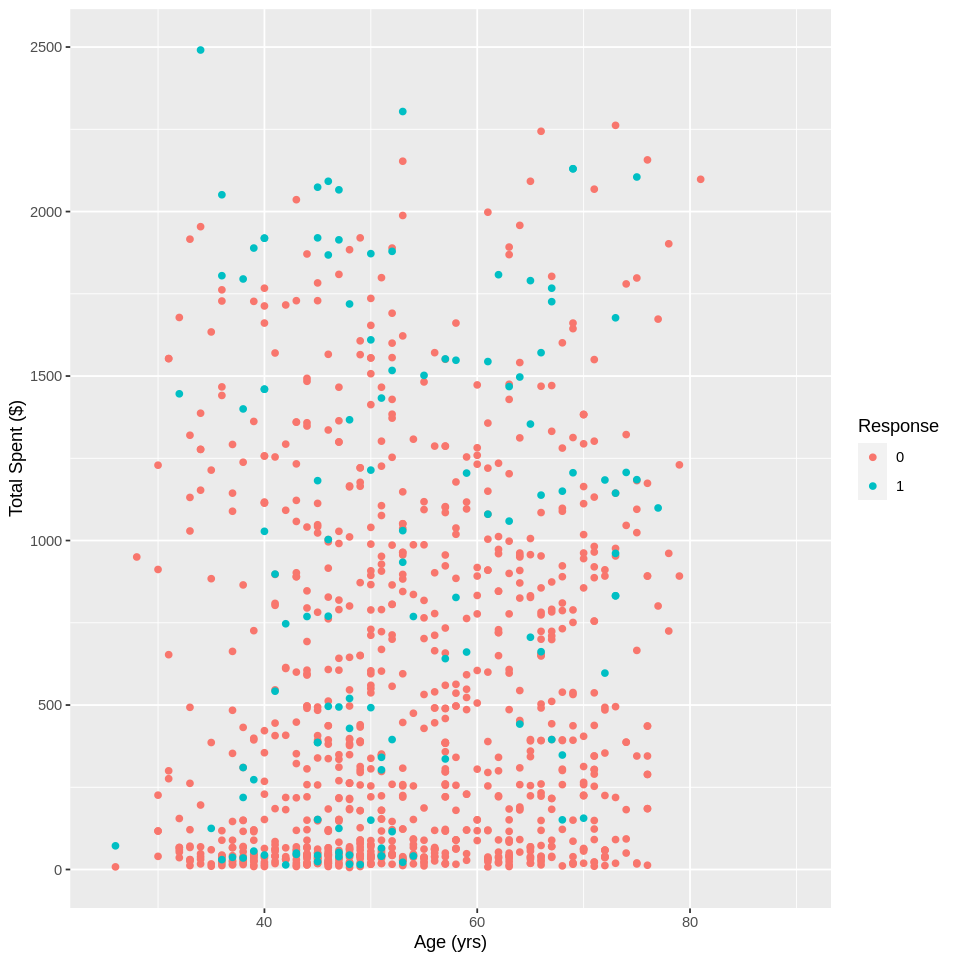

In [21]:
yes_other_scatterplot <- store_data_yes_train |>
    ggplot(aes(Age, Total_Spent, color = Response)) +
        geom_point() +
        labs(x = "Age (yrs)", y = "Total Spent ($)") +
        xlim(25, 90)
yes_other_scatterplot

We see that the yes and no points are evenly spread out through the scatterplot, so it is likely that neither of the predictors will make an effective predictor.

## Discussion:
summarize what you found

-discuss whether this is what you expected to find?

-discuss what impact could such findings have?

-discuss what future questions could this lead to?

## References